In [1]:
# from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
import numpy as np
import cv2
from transformers import pipeline
from diffusers.utils import load_image, make_image_grid
# from diffusers import StableDiffusionControlNetPipeline, UniPCMultistepScheduler
from diffusers import UniPCMultistepScheduler
from pipeline_controlnet_sync import StableDiffusionControlNetPipeline
from controlnet_sync import ControlNetModelSync
from omegaconf import OmegaConf

from SyncDreamer.ldm.util import instantiate_from_config, prepare_inputs

def load_model(cfg,ckpt,strict=True):
    config = OmegaConf.load(cfg)
    model = instantiate_from_config(config.model)
    print(f'loading model from {ckpt} ...')
    ckpt = torch.load(ckpt,map_location='cuda')
    model.load_state_dict(ckpt['state_dict'],strict=strict)
    model = model.cuda().eval()
    return model

controlnet = ControlNetModelSync.from_pretrained("models_syncdreamer_fixed2/checkpoint-14000/controlnet/", torch_dtype=torch.float32, use_safetensors=True)
cfg = 'SyncDreamer/configs/syncdreamer.yaml'
dreamer = load_model(cfg, 'SyncDreamer/ckpt/syncdreamer-pretrain.ckpt', strict=True)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Selected timesteps for ddim sampler: [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 176
 181 186 191 196 201 206 211 216 221 226 231 236 241 246 251 256 261 266
 271 276 281 286 291 296 301 306 311 316 321 326 331 336 341 346 351 356
 361 366 371 376 381 386 391 396 401 406 411 416 421 426 431 436 441 446
 451 456 461 466 471 476 481 486 491 496 501 506 511 516 521 526 531 536
 541 546 551 556 561 566 571 576 581 586 591 596 601 606 611 616 621 626
 631 636 641 646 651 656 661 666 671 676 681 686 691 696 701 706 711 716
 721 726 731 736 741 746 751 756 761 766 771 776 781 786 791 796 801 806
 811 816 821 826 831 836 841 846 851 856 861 866 871 876 881 886 891 896
 901 906 911 916 921 926 931 936 941 946 951 956 961 966 971 97

In [2]:
controlnet.to('cuda', dtype=torch.float32)
dreamer.to('cuda', dtype=torch.float32)
print()

In [3]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, dreamer=dreamer, torch_dtype=torch.float32, use_safetensors=True
)
# models_syncdreamer/checkpoint-12000

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_model_cpu_offload()

# pipe.safety_checker = lambda images, clip_input: (images, False)
from diffusers.pipelines.stable_diffusion import safety_checker

def sc(self, clip_input, images) : return images, [False for i in images]

# edit the StableDiffusionSafetyChecker class so that, when called, it just returns the images and an array of True values
safety_checker.StableDiffusionSafetyChecker.forward = sc

pipe.to('cuda', dtype=torch.float32)
print()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [4]:
import PIL

data_path = '/home/jupyter/data/'
data = {"text": "Execute a 0.0-degree clockwise rotation on the image.", "image": "images/625785a3455b478d8b72b5a7f0bd269a_000.png", "conditioning_image": "conditioning_images/625785a3455b478d8b72b5a7f0bd269a_000.png", "target_index":0}

imgPath = data_path + data['conditioning_image']
conditioning_image = PIL.Image.open(imgPath)
conditioning_image = PIL.ImageOps.exif_transpose(conditioning_image)
conditioning_image = conditioning_image.convert("RGB")
output = pipe(
    data['text'], image=conditioning_image
)
# make_image_grid([conditioning_image, output], rows=1, cols=2)

Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]


DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/envs/controlnet/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
DDIM Sampler: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


In [5]:
# import matplotlib.pyplot as plt
# image = output[1].cpu().permute((1,2,0)).numpy()
# plt.imshow(image)
# plt.show()

Rotation: 0.0 dgrees


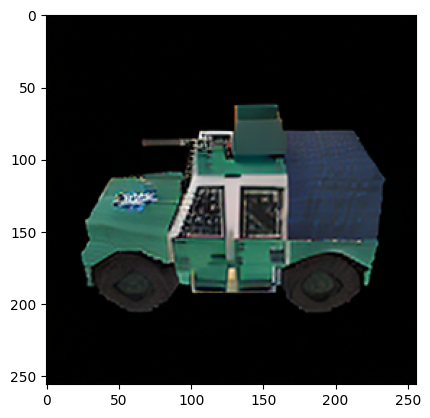

Rotation: 22.5 dgrees


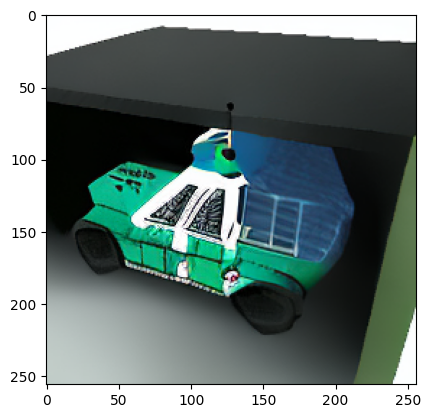

Rotation: 45.0 dgrees


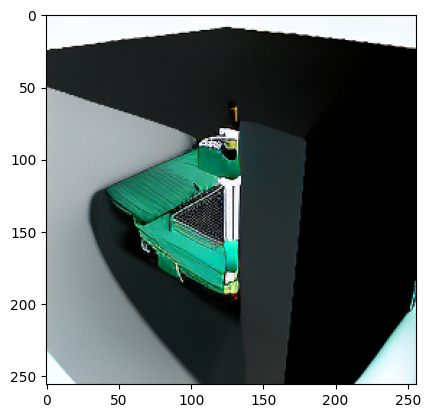

Rotation: 67.5 dgrees


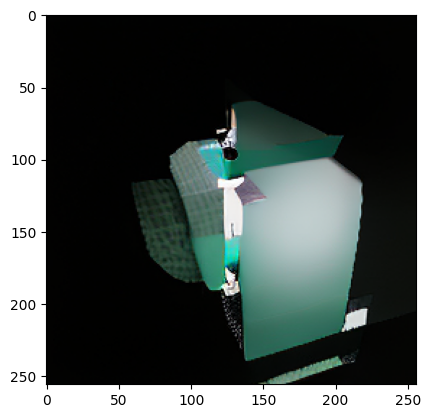

Rotation: 90.0 dgrees


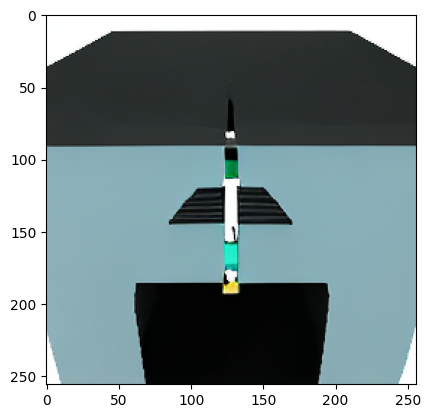

Rotation: 112.5 dgrees


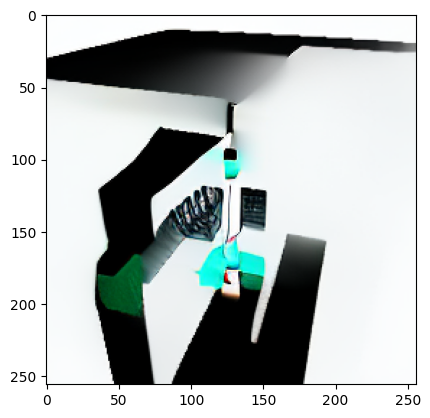

Rotation: 135.0 dgrees


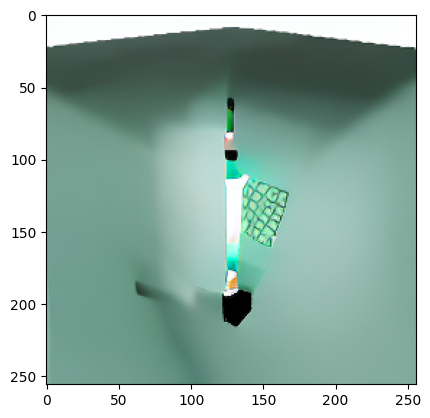

Rotation: 157.5 dgrees


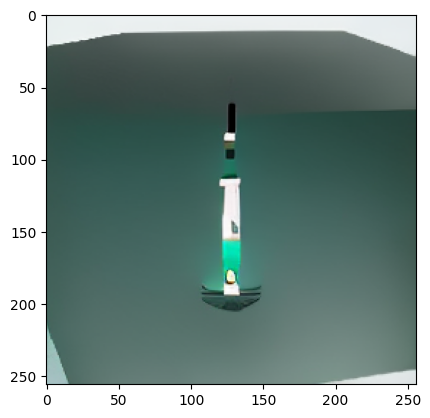

Rotation: 180.0 dgrees


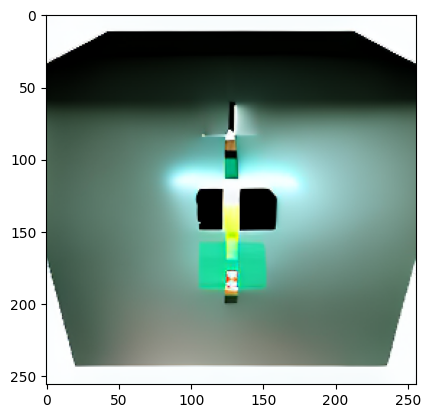

Rotation: 202.5 dgrees


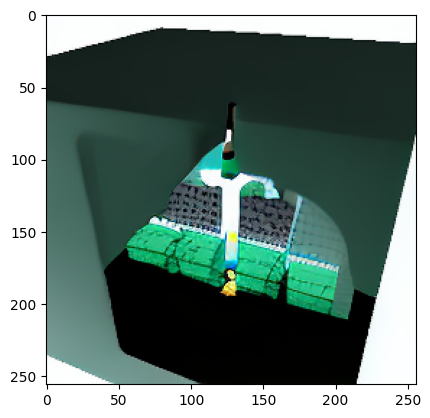

Rotation: 225.0 dgrees


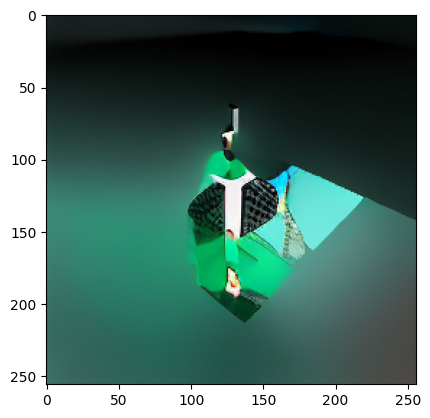

Rotation: 247.5 dgrees


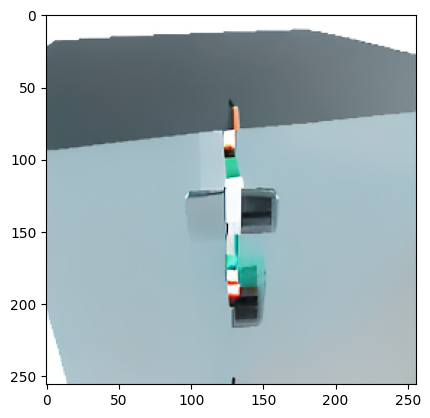

Rotation: 270.0 dgrees


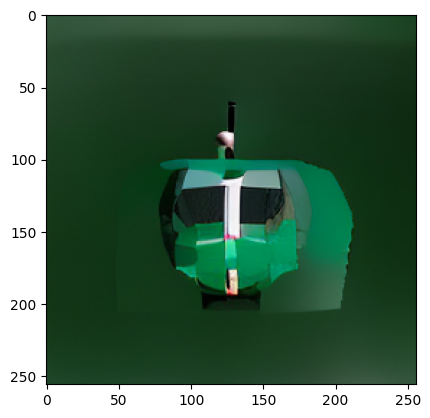

Rotation: 292.5 dgrees


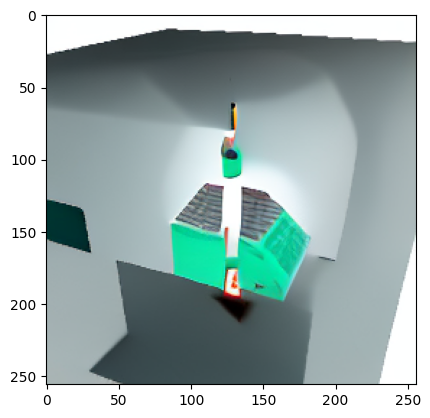

Rotation: 315.0 dgrees


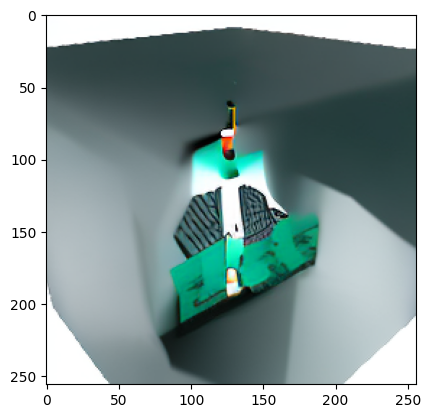

Rotation: 337.5 dgrees


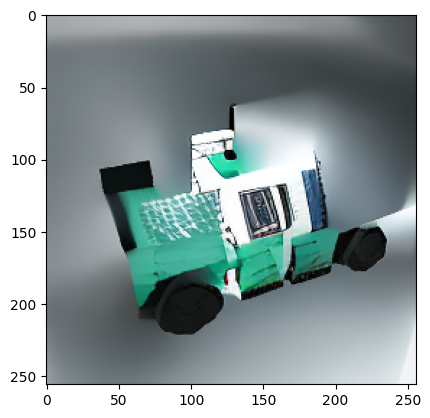

In [6]:
import matplotlib.pyplot as plt

for i in range(16):
    print('Rotation:', 22.5 * i, 'dgrees')
    plt.imshow(output[i,:,:,:])
    plt.show()

In [7]:
cv2.imwrite('test.png', cv2.cvtColor(cv2.imread('/home/jupyter/data/images/' + paths[0]), cv2.COLOR_BGR2RGB))

NameError: name 'paths' is not defined

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

def display_imgs(imgs, titles, w, h):
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(40,40))
    for i in range(len(imgs)):
        ax = fig.add_subplot(h,w,i + 1)
        ax.set_title(titles[i])
        ax.axis('off')
        ax.imshow(imgs[i],None)
    plt.tight_layout()
    plt.axis('off')
#     plt.set_axis_off()
    plt.grid(False)
    plt.show()
        
w = 8
h = 2

titles = []
imgs = []
for i in range(16):
    imgs.append(output[i])
    titles.append(str(i * 22.5) + ' degrees')
display_imgs(imgs, titles, w, h)

In [ ]:
# conditioning_image

In [ ]:
from PIL import Image, ImageOps

# PIL = importlib.import_module('PIL.Image')
# PIL = importlib.import_module('PIL.ImageOps')

data_path = '/home/jupyter/data/images/625785a3455b478d8b72b5a7f0bd269a_001.png'

gt = Image.open(data_path)
gt = ImageOps.exif_transpose(gt)
gt = gt.convert("RGB")
gt

In [ ]:
import os

paths = sorted(os.listdir('/home/jupyter/data/images/'))
paths[:10]

In [ ]:
import cv2
import matplotlib.pyplot as plt

for p in paths[:16]:
    img = cv2.imread('/home/jupyter/data/images/' + p)
    plt.imshow(img)
    plt.show()